## **Fine-tuning BERT for Sentence-Level Slang Identification**

In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install required libraries
%pip install datasets evaluate transformers torch
%pip install matplotlib scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


### imports

In [4]:

# Import libraries
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import KFold
import evaluate
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


### Evaluation scoring

In [6]:

# Load evaluation metrics
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

# Define metric computation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predicted_classes = np.argmax(predictions, axis=1)

    # Compute metrics
    acc = accuracy.compute(predictions=predicted_classes, references=labels)["accuracy"]
    prec = precision.compute(predictions=predicted_classes, references=labels)["precision"]
    rec = recall.compute(predictions=predicted_classes, references=labels)["recall"]
    f1_score = f1.compute(predictions=predicted_classes, references=labels)["f1"]

    return {
        "accuracy": round(acc, 3),
        "precision": round(prec, 3),
        "recall": round(rec, 3),
        "f1": round(f1_score, 3),
    }


### load data

In [7]:

# Load your Hugging Face dataset
dataset = load_dataset("SohailaMohammed/BERTSlangDetection")
# Use the 'train' split for cross-validation
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Initialize tokenizer and model
model_name = "bert-large-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Update based on your labels
    id2label={0: "Not Slang", 1: "Slang"},
    label2id={"Not Slang": 0, "Slang": 1},
)


/home/sohaila/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Tokenize the test dataset
tokenized_test = test_dataset.map(
    lambda x: tokenizer(x["text"], truncation=True, padding="max_length"), batched=True
)
tokenized_test = tokenized_test.remove_columns(["text"])
tokenized_test.set_format("torch")

### Freeze base model

In [9]:
# freeze base model parameters
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# unfreeze base model pooling layers
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

### Cross validation

In [10]:

# Prepare for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []

for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
    print(f"\n=== Fold {fold + 1} ===")

    # Split dataset into training and validation sets
    train_data = train_dataset.select(train_index)
    val_data = train_dataset.select(val_index)

    # Tokenize datasets
    tokenized_train = train_data.map(
        lambda x: tokenizer(x["text"], truncation=True, padding="max_length"), batched=True
    )
    tokenized_val = val_data.map(
        lambda x: tokenizer(x["text"], truncation=True, padding="max_length"), batched=True
    )

    # Remove unnecessary columns
    tokenized_train = tokenized_train.remove_columns(["text"])
    tokenized_val = tokenized_val.remove_columns(["text"])

    # Set format for PyTorch
    tokenized_train.set_format("torch")
    tokenized_val.set_format("torch")

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_dir="./logs",
        logging_steps=10,
        load_best_model_at_end=True,
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model on the validation set
    metrics = trainer.evaluate()
    print(f"Metrics for Fold {fold + 1}: {metrics}")
    fold_metrics.append(metrics)

# Compute average metrics across folds
avg_metrics = {key: np.mean([m[key] for m in fold_metrics]) for key in fold_metrics[0].keys()}
print("\n=== Average Metrics Across Folds ===")
print(avg_metrics)



=== Fold 1 ===


  0%|          | 0/2744 [00:00<?, ?it/s]

{'loss': 0.7476, 'grad_norm': 16.12126350402832, 'learning_rate': 4.9817784256559767e-05, 'epoch': 0.01}
{'loss': 0.7084, 'grad_norm': 3.198113441467285, 'learning_rate': 4.963556851311954e-05, 'epoch': 0.03}
{'loss': 0.6921, 'grad_norm': 6.431217670440674, 'learning_rate': 4.94533527696793e-05, 'epoch': 0.04}
{'loss': 0.6518, 'grad_norm': 2.902946710586548, 'learning_rate': 4.9271137026239066e-05, 'epoch': 0.06}
{'loss': 0.6234, 'grad_norm': 3.1559033393859863, 'learning_rate': 4.908892128279884e-05, 'epoch': 0.07}
{'loss': 0.6398, 'grad_norm': 10.458946228027344, 'learning_rate': 4.890670553935861e-05, 'epoch': 0.09}
{'loss': 0.6034, 'grad_norm': 4.466564655303955, 'learning_rate': 4.872448979591837e-05, 'epoch': 0.1}
{'loss': 0.5995, 'grad_norm': 2.8594248294830322, 'learning_rate': 4.8542274052478136e-05, 'epoch': 0.12}
{'loss': 0.541, 'grad_norm': 5.0985636711120605, 'learning_rate': 4.83600583090379e-05, 'epoch': 0.13}
{'loss': 0.5791, 'grad_norm': 3.151251792907715, 'learning_ra

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.40102216601371765, 'eval_accuracy': 0.802, 'eval_precision': 0.799, 'eval_recall': 0.805, 'eval_f1': 0.802, 'eval_runtime': 106.5947, 'eval_samples_per_second': 12.871, 'eval_steps_per_second': 1.614, 'epoch': 1.0}
{'loss': 0.4451, 'grad_norm': 3.439177989959717, 'learning_rate': 3.742711370262391e-05, 'epoch': 1.01}
{'loss': 0.331, 'grad_norm': 1.7639285326004028, 'learning_rate': 3.724489795918368e-05, 'epoch': 1.02}
{'loss': 0.4077, 'grad_norm': 9.129340171813965, 'learning_rate': 3.706268221574344e-05, 'epoch': 1.03}
{'loss': 0.3148, 'grad_norm': 4.463481426239014, 'learning_rate': 3.688046647230321e-05, 'epoch': 1.05}
{'loss': 0.3553, 'grad_norm': 3.0421254634857178, 'learning_rate': 3.669825072886298e-05, 'epoch': 1.06}
{'loss': 0.5022, 'grad_norm': 3.35418963432312, 'learning_rate': 3.651603498542274e-05, 'epoch': 1.08}
{'loss': 0.3429, 'grad_norm': 2.100095748901367, 'learning_rate': 3.6333819241982507e-05, 'epoch': 1.09}
{'loss': 0.4518, 'grad_norm': 2.41359329

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.36202067136764526, 'eval_accuracy': 0.838, 'eval_precision': 0.865, 'eval_recall': 0.799, 'eval_f1': 0.831, 'eval_runtime': 107.7948, 'eval_samples_per_second': 12.728, 'eval_steps_per_second': 1.596, 'epoch': 2.0}
{'loss': 0.257, 'grad_norm': 2.995408773422241, 'learning_rate': 2.4854227405247817e-05, 'epoch': 2.01}
{'loss': 0.3055, 'grad_norm': 3.4650275707244873, 'learning_rate': 2.467201166180758e-05, 'epoch': 2.03}
{'loss': 0.283, 'grad_norm': 5.3010101318359375, 'learning_rate': 2.448979591836735e-05, 'epoch': 2.04}
{'loss': 0.3129, 'grad_norm': 1.4090349674224854, 'learning_rate': 2.4307580174927113e-05, 'epoch': 2.06}
{'loss': 0.3655, 'grad_norm': 2.2303895950317383, 'learning_rate': 2.4125364431486884e-05, 'epoch': 2.07}
{'loss': 0.2902, 'grad_norm': 1.8908720016479492, 'learning_rate': 2.3943148688046648e-05, 'epoch': 2.08}
{'loss': 0.3158, 'grad_norm': 2.9666330814361572, 'learning_rate': 2.3760932944606415e-05, 'epoch': 2.1}
{'loss': 0.401, 'grad_norm': 4.02

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.34656214714050293, 'eval_accuracy': 0.852, 'eval_precision': 0.845, 'eval_recall': 0.861, 'eval_f1': 0.853, 'eval_runtime': 108.1498, 'eval_samples_per_second': 12.686, 'eval_steps_per_second': 1.59, 'epoch': 3.0}
{'loss': 0.3085, 'grad_norm': 1.3643286228179932, 'learning_rate': 1.2463556851311954e-05, 'epoch': 3.0}
{'loss': 0.4025, 'grad_norm': 2.294041872024536, 'learning_rate': 1.228134110787172e-05, 'epoch': 3.02}
{'loss': 0.358, 'grad_norm': 1.490899920463562, 'learning_rate': 1.2099125364431488e-05, 'epoch': 3.03}
{'loss': 0.2636, 'grad_norm': 0.48556599020957947, 'learning_rate': 1.1916909620991254e-05, 'epoch': 3.05}
{'loss': 0.4773, 'grad_norm': 4.006315231323242, 'learning_rate': 1.1734693877551021e-05, 'epoch': 3.06}
{'loss': 0.2435, 'grad_norm': 4.540927886962891, 'learning_rate': 1.1552478134110787e-05, 'epoch': 3.08}
{'loss': 0.3157, 'grad_norm': 1.5025603771209717, 'learning_rate': 1.1370262390670553e-05, 'epoch': 3.09}
{'loss': 0.3003, 'grad_norm': 1.92

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.343895822763443, 'eval_accuracy': 0.854, 'eval_precision': 0.852, 'eval_recall': 0.855, 'eval_f1': 0.854, 'eval_runtime': 109.4035, 'eval_samples_per_second': 12.541, 'eval_steps_per_second': 1.572, 'epoch': 4.0}
{'train_runtime': 2210.1745, 'train_samples_per_second': 9.93, 'train_steps_per_second': 1.242, 'train_loss': 0.37210772114835744, 'epoch': 4.0}


  0%|          | 0/172 [00:00<?, ?it/s]

Metrics for Fold 1: {'eval_loss': 0.343895822763443, 'eval_accuracy': 0.854, 'eval_precision': 0.852, 'eval_recall': 0.855, 'eval_f1': 0.854, 'eval_runtime': 110.2595, 'eval_samples_per_second': 12.443, 'eval_steps_per_second': 1.56, 'epoch': 4.0}

=== Fold 2 ===


Map:   0%|          | 0/5487 [00:00<?, ? examples/s]

Map:   0%|          | 0/1372 [00:00<?, ? examples/s]

  0%|          | 0/2744 [00:00<?, ?it/s]

{'loss': 0.2574, 'grad_norm': 3.1713311672210693, 'learning_rate': 4.9817784256559767e-05, 'epoch': 0.01}
{'loss': 0.3093, 'grad_norm': 5.52377986907959, 'learning_rate': 4.963556851311954e-05, 'epoch': 0.03}
{'loss': 0.3116, 'grad_norm': 0.7625554800033569, 'learning_rate': 4.94533527696793e-05, 'epoch': 0.04}
{'loss': 0.3699, 'grad_norm': 4.77701473236084, 'learning_rate': 4.9271137026239066e-05, 'epoch': 0.06}
{'loss': 0.3631, 'grad_norm': 2.1953020095825195, 'learning_rate': 4.908892128279884e-05, 'epoch': 0.07}
{'loss': 0.396, 'grad_norm': 1.6401638984680176, 'learning_rate': 4.890670553935861e-05, 'epoch': 0.09}
{'loss': 0.3634, 'grad_norm': 2.1504087448120117, 'learning_rate': 4.872448979591837e-05, 'epoch': 0.1}
{'loss': 0.442, 'grad_norm': 7.016395092010498, 'learning_rate': 4.8542274052478136e-05, 'epoch': 0.12}
{'loss': 0.3008, 'grad_norm': 3.9307942390441895, 'learning_rate': 4.83600583090379e-05, 'epoch': 0.13}
{'loss': 0.3469, 'grad_norm': 2.5019919872283936, 'learning_ra

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.3098214268684387, 'eval_accuracy': 0.86, 'eval_precision': 0.889, 'eval_recall': 0.825, 'eval_f1': 0.856, 'eval_runtime': 110.7099, 'eval_samples_per_second': 12.393, 'eval_steps_per_second': 1.554, 'epoch': 1.0}
{'loss': 0.2746, 'grad_norm': 1.589597225189209, 'learning_rate': 3.742711370262391e-05, 'epoch': 1.01}
{'loss': 0.2037, 'grad_norm': 1.0862318277359009, 'learning_rate': 3.724489795918368e-05, 'epoch': 1.02}
{'loss': 0.2893, 'grad_norm': 5.208625316619873, 'learning_rate': 3.706268221574344e-05, 'epoch': 1.03}
{'loss': 0.3916, 'grad_norm': 3.304964303970337, 'learning_rate': 3.688046647230321e-05, 'epoch': 1.05}
{'loss': 0.4687, 'grad_norm': 2.0075669288635254, 'learning_rate': 3.669825072886298e-05, 'epoch': 1.06}
{'loss': 0.3128, 'grad_norm': 4.586455821990967, 'learning_rate': 3.651603498542274e-05, 'epoch': 1.08}
{'loss': 0.3651, 'grad_norm': 2.2416651248931885, 'learning_rate': 3.6333819241982507e-05, 'epoch': 1.09}
{'loss': 0.2872, 'grad_norm': 4.0080585

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.3013755679130554, 'eval_accuracy': 0.873, 'eval_precision': 0.886, 'eval_recall': 0.858, 'eval_f1': 0.872, 'eval_runtime': 111.5303, 'eval_samples_per_second': 12.302, 'eval_steps_per_second': 1.542, 'epoch': 2.0}
{'loss': 0.2952, 'grad_norm': 2.0132014751434326, 'learning_rate': 2.4854227405247817e-05, 'epoch': 2.01}
{'loss': 0.2751, 'grad_norm': 3.1336212158203125, 'learning_rate': 2.467201166180758e-05, 'epoch': 2.03}
{'loss': 0.4038, 'grad_norm': 2.3670246601104736, 'learning_rate': 2.448979591836735e-05, 'epoch': 2.04}
{'loss': 0.2229, 'grad_norm': 9.187222480773926, 'learning_rate': 2.4307580174927113e-05, 'epoch': 2.06}
{'loss': 0.3417, 'grad_norm': 5.875116348266602, 'learning_rate': 2.4125364431486884e-05, 'epoch': 2.07}
{'loss': 0.3182, 'grad_norm': 1.7424362897872925, 'learning_rate': 2.3943148688046648e-05, 'epoch': 2.08}
{'loss': 0.3731, 'grad_norm': 1.959274172782898, 'learning_rate': 2.3760932944606415e-05, 'epoch': 2.1}
{'loss': 0.2033, 'grad_norm': 2.04

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.3077111542224884, 'eval_accuracy': 0.865, 'eval_precision': 0.894, 'eval_recall': 0.831, 'eval_f1': 0.861, 'eval_runtime': 112.7685, 'eval_samples_per_second': 12.167, 'eval_steps_per_second': 1.525, 'epoch': 3.0}
{'loss': 0.2835, 'grad_norm': 3.2890737056732178, 'learning_rate': 1.2463556851311954e-05, 'epoch': 3.0}
{'loss': 0.2213, 'grad_norm': 2.843114137649536, 'learning_rate': 1.228134110787172e-05, 'epoch': 3.02}
{'loss': 0.4469, 'grad_norm': 3.2134764194488525, 'learning_rate': 1.2099125364431488e-05, 'epoch': 3.03}
{'loss': 0.1482, 'grad_norm': 3.688918352127075, 'learning_rate': 1.1916909620991254e-05, 'epoch': 3.05}
{'loss': 0.3956, 'grad_norm': 1.6904289722442627, 'learning_rate': 1.1734693877551021e-05, 'epoch': 3.06}
{'loss': 0.4149, 'grad_norm': 5.9681901931762695, 'learning_rate': 1.1552478134110787e-05, 'epoch': 3.08}
{'loss': 0.268, 'grad_norm': 3.485898971557617, 'learning_rate': 1.1370262390670553e-05, 'epoch': 3.09}
{'loss': 0.2222, 'grad_norm': 2.82

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.3076520562171936, 'eval_accuracy': 0.867, 'eval_precision': 0.901, 'eval_recall': 0.828, 'eval_f1': 0.863, 'eval_runtime': 111.628, 'eval_samples_per_second': 12.291, 'eval_steps_per_second': 1.541, 'epoch': 4.0}
{'train_runtime': 2299.728, 'train_samples_per_second': 9.544, 'train_steps_per_second': 1.193, 'train_loss': 0.31250980683214113, 'epoch': 4.0}


  0%|          | 0/172 [00:00<?, ?it/s]

Metrics for Fold 2: {'eval_loss': 0.3013755679130554, 'eval_accuracy': 0.873, 'eval_precision': 0.886, 'eval_recall': 0.858, 'eval_f1': 0.872, 'eval_runtime': 111.1984, 'eval_samples_per_second': 12.338, 'eval_steps_per_second': 1.547, 'epoch': 4.0}

=== Fold 3 ===


Map:   0%|          | 0/5487 [00:00<?, ? examples/s]

Map:   0%|          | 0/1372 [00:00<?, ? examples/s]

  0%|          | 0/2744 [00:00<?, ?it/s]

{'loss': 0.4092, 'grad_norm': 3.524280309677124, 'learning_rate': 4.9817784256559767e-05, 'epoch': 0.01}
{'loss': 0.2695, 'grad_norm': 6.277135372161865, 'learning_rate': 4.963556851311954e-05, 'epoch': 0.03}
{'loss': 0.4512, 'grad_norm': 5.251201152801514, 'learning_rate': 4.94533527696793e-05, 'epoch': 0.04}
{'loss': 0.3135, 'grad_norm': 9.240917205810547, 'learning_rate': 4.9271137026239066e-05, 'epoch': 0.06}
{'loss': 0.2828, 'grad_norm': 2.2735114097595215, 'learning_rate': 4.908892128279884e-05, 'epoch': 0.07}
{'loss': 0.3241, 'grad_norm': 3.270202398300171, 'learning_rate': 4.890670553935861e-05, 'epoch': 0.09}
{'loss': 0.2166, 'grad_norm': 3.1319916248321533, 'learning_rate': 4.872448979591837e-05, 'epoch': 0.1}
{'loss': 0.4205, 'grad_norm': 5.265421390533447, 'learning_rate': 4.8542274052478136e-05, 'epoch': 0.12}
{'loss': 0.2866, 'grad_norm': 3.0711328983306885, 'learning_rate': 4.83600583090379e-05, 'epoch': 0.13}
{'loss': 0.4667, 'grad_norm': 2.234607219696045, 'learning_ra

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.30300694704055786, 'eval_accuracy': 0.872, 'eval_precision': 0.917, 'eval_recall': 0.824, 'eval_f1': 0.868, 'eval_runtime': 110.7216, 'eval_samples_per_second': 12.391, 'eval_steps_per_second': 1.553, 'epoch': 1.0}
{'loss': 0.2111, 'grad_norm': 5.432157039642334, 'learning_rate': 3.742711370262391e-05, 'epoch': 1.01}
{'loss': 0.2301, 'grad_norm': 3.231729030609131, 'learning_rate': 3.724489795918368e-05, 'epoch': 1.02}
{'loss': 0.1889, 'grad_norm': 2.0435023307800293, 'learning_rate': 3.706268221574344e-05, 'epoch': 1.03}
{'loss': 0.356, 'grad_norm': 4.66110897064209, 'learning_rate': 3.688046647230321e-05, 'epoch': 1.05}
{'loss': 0.267, 'grad_norm': 4.125018119812012, 'learning_rate': 3.669825072886298e-05, 'epoch': 1.06}
{'loss': 0.2877, 'grad_norm': 1.4115298986434937, 'learning_rate': 3.651603498542274e-05, 'epoch': 1.08}
{'loss': 0.3535, 'grad_norm': 6.554035186767578, 'learning_rate': 3.6333819241982507e-05, 'epoch': 1.09}
{'loss': 0.3133, 'grad_norm': 4.118865489

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.31037023663520813, 'eval_accuracy': 0.867, 'eval_precision': 0.919, 'eval_recall': 0.809, 'eval_f1': 0.86, 'eval_runtime': 108.993, 'eval_samples_per_second': 12.588, 'eval_steps_per_second': 1.578, 'epoch': 2.0}
{'loss': 0.3903, 'grad_norm': 4.329604148864746, 'learning_rate': 2.4854227405247817e-05, 'epoch': 2.01}
{'loss': 0.3526, 'grad_norm': 2.063004970550537, 'learning_rate': 2.467201166180758e-05, 'epoch': 2.03}
{'loss': 0.2861, 'grad_norm': 10.971098899841309, 'learning_rate': 2.448979591836735e-05, 'epoch': 2.04}
{'loss': 0.209, 'grad_norm': 7.908809661865234, 'learning_rate': 2.4307580174927113e-05, 'epoch': 2.06}
{'loss': 0.4281, 'grad_norm': 6.704098701477051, 'learning_rate': 2.4125364431486884e-05, 'epoch': 2.07}
{'loss': 0.194, 'grad_norm': 0.7828868627548218, 'learning_rate': 2.3943148688046648e-05, 'epoch': 2.08}
{'loss': 0.3292, 'grad_norm': 1.551058053970337, 'learning_rate': 2.3760932944606415e-05, 'epoch': 2.1}
{'loss': 0.2923, 'grad_norm': 2.0495362

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.3003780245780945, 'eval_accuracy': 0.873, 'eval_precision': 0.913, 'eval_recall': 0.829, 'eval_f1': 0.869, 'eval_runtime': 108.5603, 'eval_samples_per_second': 12.638, 'eval_steps_per_second': 1.584, 'epoch': 3.0}
{'loss': 0.2136, 'grad_norm': 6.148746967315674, 'learning_rate': 1.2463556851311954e-05, 'epoch': 3.0}
{'loss': 0.2094, 'grad_norm': 3.321812391281128, 'learning_rate': 1.228134110787172e-05, 'epoch': 3.02}
{'loss': 0.2706, 'grad_norm': 5.787311553955078, 'learning_rate': 1.2099125364431488e-05, 'epoch': 3.03}
{'loss': 0.2049, 'grad_norm': 1.0388909578323364, 'learning_rate': 1.1916909620991254e-05, 'epoch': 3.05}
{'loss': 0.3031, 'grad_norm': 1.067147135734558, 'learning_rate': 1.1734693877551021e-05, 'epoch': 3.06}
{'loss': 0.3363, 'grad_norm': 7.740254878997803, 'learning_rate': 1.1552478134110787e-05, 'epoch': 3.08}
{'loss': 0.3308, 'grad_norm': 1.6873880624771118, 'learning_rate': 1.1370262390670553e-05, 'epoch': 3.09}
{'loss': 0.408, 'grad_norm': 1.2343

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.2967533767223358, 'eval_accuracy': 0.876, 'eval_precision': 0.909, 'eval_recall': 0.841, 'eval_f1': 0.873, 'eval_runtime': 108.2295, 'eval_samples_per_second': 12.677, 'eval_steps_per_second': 1.589, 'epoch': 4.0}
{'train_runtime': 2254.7826, 'train_samples_per_second': 9.734, 'train_steps_per_second': 1.217, 'train_loss': 0.305105774943057, 'epoch': 4.0}


  0%|          | 0/172 [00:00<?, ?it/s]

Metrics for Fold 3: {'eval_loss': 0.2967533767223358, 'eval_accuracy': 0.876, 'eval_precision': 0.909, 'eval_recall': 0.841, 'eval_f1': 0.873, 'eval_runtime': 107.98, 'eval_samples_per_second': 12.706, 'eval_steps_per_second': 1.593, 'epoch': 4.0}

=== Fold 4 ===


Map:   0%|          | 0/5487 [00:00<?, ? examples/s]

Map:   0%|          | 0/1372 [00:00<?, ? examples/s]

  0%|          | 0/2744 [00:00<?, ?it/s]

{'loss': 0.294, 'grad_norm': 1.5777612924575806, 'learning_rate': 4.9817784256559767e-05, 'epoch': 0.01}
{'loss': 0.3013, 'grad_norm': 2.185016632080078, 'learning_rate': 4.963556851311954e-05, 'epoch': 0.03}
{'loss': 0.3935, 'grad_norm': 8.090497016906738, 'learning_rate': 4.94533527696793e-05, 'epoch': 0.04}
{'loss': 0.2442, 'grad_norm': 0.5519066452980042, 'learning_rate': 4.9271137026239066e-05, 'epoch': 0.06}
{'loss': 0.2531, 'grad_norm': 2.1354188919067383, 'learning_rate': 4.908892128279884e-05, 'epoch': 0.07}
{'loss': 0.2224, 'grad_norm': 2.0819828510284424, 'learning_rate': 4.890670553935861e-05, 'epoch': 0.09}
{'loss': 0.3443, 'grad_norm': 6.839046955108643, 'learning_rate': 4.872448979591837e-05, 'epoch': 0.1}
{'loss': 0.3122, 'grad_norm': 0.8945557475090027, 'learning_rate': 4.8542274052478136e-05, 'epoch': 0.12}
{'loss': 0.2017, 'grad_norm': 1.5333894491195679, 'learning_rate': 4.83600583090379e-05, 'epoch': 0.13}
{'loss': 0.3448, 'grad_norm': 9.59171199798584, 'learning_r

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.2689450681209564, 'eval_accuracy': 0.883, 'eval_precision': 0.889, 'eval_recall': 0.881, 'eval_f1': 0.885, 'eval_runtime': 108.2817, 'eval_samples_per_second': 12.671, 'eval_steps_per_second': 1.588, 'epoch': 1.0}
{'loss': 0.2896, 'grad_norm': 3.8759288787841797, 'learning_rate': 3.742711370262391e-05, 'epoch': 1.01}
{'loss': 0.368, 'grad_norm': 1.5689414739608765, 'learning_rate': 3.724489795918368e-05, 'epoch': 1.02}
{'loss': 0.2139, 'grad_norm': 2.3327624797821045, 'learning_rate': 3.706268221574344e-05, 'epoch': 1.03}
{'loss': 0.3162, 'grad_norm': 3.952810525894165, 'learning_rate': 3.688046647230321e-05, 'epoch': 1.05}
{'loss': 0.1804, 'grad_norm': 7.425475120544434, 'learning_rate': 3.669825072886298e-05, 'epoch': 1.06}
{'loss': 0.5219, 'grad_norm': 9.479818344116211, 'learning_rate': 3.651603498542274e-05, 'epoch': 1.08}
{'loss': 0.2583, 'grad_norm': 4.742329120635986, 'learning_rate': 3.6333819241982507e-05, 'epoch': 1.09}
{'loss': 0.2615, 'grad_norm': 5.7305741

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.2716410458087921, 'eval_accuracy': 0.888, 'eval_precision': 0.883, 'eval_recall': 0.898, 'eval_f1': 0.89, 'eval_runtime': 107.921, 'eval_samples_per_second': 12.713, 'eval_steps_per_second': 1.594, 'epoch': 2.0}
{'loss': 0.1614, 'grad_norm': 2.6701595783233643, 'learning_rate': 2.4854227405247817e-05, 'epoch': 2.01}
{'loss': 0.3383, 'grad_norm': 0.6138033270835876, 'learning_rate': 2.467201166180758e-05, 'epoch': 2.03}
{'loss': 0.3388, 'grad_norm': 7.187184810638428, 'learning_rate': 2.448979591836735e-05, 'epoch': 2.04}
{'loss': 0.2163, 'grad_norm': 3.667304277420044, 'learning_rate': 2.4307580174927113e-05, 'epoch': 2.06}
{'loss': 0.1562, 'grad_norm': 4.43489408493042, 'learning_rate': 2.4125364431486884e-05, 'epoch': 2.07}
{'loss': 0.3405, 'grad_norm': 5.832674980163574, 'learning_rate': 2.3943148688046648e-05, 'epoch': 2.08}
{'loss': 0.1512, 'grad_norm': 0.8662011027336121, 'learning_rate': 2.3760932944606415e-05, 'epoch': 2.1}
{'loss': 0.376, 'grad_norm': 2.1069324

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.27918440103530884, 'eval_accuracy': 0.875, 'eval_precision': 0.907, 'eval_recall': 0.839, 'eval_f1': 0.872, 'eval_runtime': 108.2005, 'eval_samples_per_second': 12.68, 'eval_steps_per_second': 1.59, 'epoch': 3.0}
{'loss': 0.1369, 'grad_norm': 1.217319130897522, 'learning_rate': 1.2463556851311954e-05, 'epoch': 3.0}
{'loss': 0.301, 'grad_norm': 2.8761279582977295, 'learning_rate': 1.228134110787172e-05, 'epoch': 3.02}
{'loss': 0.1968, 'grad_norm': 2.755160331726074, 'learning_rate': 1.2099125364431488e-05, 'epoch': 3.03}
{'loss': 0.3553, 'grad_norm': 3.7310945987701416, 'learning_rate': 1.1916909620991254e-05, 'epoch': 3.05}
{'loss': 0.2693, 'grad_norm': 3.185237169265747, 'learning_rate': 1.1734693877551021e-05, 'epoch': 3.06}
{'loss': 0.2265, 'grad_norm': 1.7275891304016113, 'learning_rate': 1.1552478134110787e-05, 'epoch': 3.08}
{'loss': 0.1462, 'grad_norm': 2.685598134994507, 'learning_rate': 1.1370262390670553e-05, 'epoch': 3.09}
{'loss': 0.4334, 'grad_norm': 11.748

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.27306869626045227, 'eval_accuracy': 0.877, 'eval_precision': 0.898, 'eval_recall': 0.855, 'eval_f1': 0.876, 'eval_runtime': 108.5534, 'eval_samples_per_second': 12.639, 'eval_steps_per_second': 1.584, 'epoch': 4.0}
{'train_runtime': 2228.3155, 'train_samples_per_second': 9.85, 'train_steps_per_second': 1.231, 'train_loss': 0.2954501288103988, 'epoch': 4.0}


  0%|          | 0/172 [00:00<?, ?it/s]

Metrics for Fold 4: {'eval_loss': 0.2689450681209564, 'eval_accuracy': 0.883, 'eval_precision': 0.889, 'eval_recall': 0.881, 'eval_f1': 0.885, 'eval_runtime': 108.4423, 'eval_samples_per_second': 12.652, 'eval_steps_per_second': 1.586, 'epoch': 4.0}

=== Fold 5 ===


Map:   0%|          | 0/5488 [00:00<?, ? examples/s]

Map:   0%|          | 0/1371 [00:00<?, ? examples/s]

  0%|          | 0/2744 [00:00<?, ?it/s]

{'loss': 0.3797, 'grad_norm': 6.625184535980225, 'learning_rate': 4.9817784256559767e-05, 'epoch': 0.01}
{'loss': 0.3027, 'grad_norm': 0.5626382231712341, 'learning_rate': 4.963556851311954e-05, 'epoch': 0.03}
{'loss': 0.363, 'grad_norm': 2.7582218647003174, 'learning_rate': 4.94533527696793e-05, 'epoch': 0.04}
{'loss': 0.3847, 'grad_norm': 0.6417010426521301, 'learning_rate': 4.9271137026239066e-05, 'epoch': 0.06}
{'loss': 0.3734, 'grad_norm': 1.231757640838623, 'learning_rate': 4.908892128279884e-05, 'epoch': 0.07}
{'loss': 0.1582, 'grad_norm': 1.7086851596832275, 'learning_rate': 4.890670553935861e-05, 'epoch': 0.09}
{'loss': 0.2986, 'grad_norm': 3.4796154499053955, 'learning_rate': 4.872448979591837e-05, 'epoch': 0.1}
{'loss': 0.2741, 'grad_norm': 1.6355061531066895, 'learning_rate': 4.8542274052478136e-05, 'epoch': 0.12}
{'loss': 0.2954, 'grad_norm': 4.066363334655762, 'learning_rate': 4.83600583090379e-05, 'epoch': 0.13}
{'loss': 0.2668, 'grad_norm': 8.497925758361816, 'learning_

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.2434164434671402, 'eval_accuracy': 0.9, 'eval_precision': 0.882, 'eval_recall': 0.913, 'eval_f1': 0.897, 'eval_runtime': 108.6664, 'eval_samples_per_second': 12.617, 'eval_steps_per_second': 1.583, 'epoch': 1.0}
{'loss': 0.361, 'grad_norm': 4.648877143859863, 'learning_rate': 3.742711370262391e-05, 'epoch': 1.01}
{'loss': 0.3292, 'grad_norm': 3.1039645671844482, 'learning_rate': 3.724489795918368e-05, 'epoch': 1.02}
{'loss': 0.3183, 'grad_norm': 5.408616542816162, 'learning_rate': 3.706268221574344e-05, 'epoch': 1.03}
{'loss': 0.2675, 'grad_norm': 2.860672950744629, 'learning_rate': 3.688046647230321e-05, 'epoch': 1.05}
{'loss': 0.3622, 'grad_norm': 5.121240139007568, 'learning_rate': 3.669825072886298e-05, 'epoch': 1.06}
{'loss': 0.3186, 'grad_norm': 1.9441465139389038, 'learning_rate': 3.651603498542274e-05, 'epoch': 1.08}
{'loss': 0.2239, 'grad_norm': 4.033145427703857, 'learning_rate': 3.6333819241982507e-05, 'epoch': 1.09}
{'loss': 0.3977, 'grad_norm': 2.6082558631

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.25254949927330017, 'eval_accuracy': 0.895, 'eval_precision': 0.867, 'eval_recall': 0.922, 'eval_f1': 0.894, 'eval_runtime': 108.314, 'eval_samples_per_second': 12.658, 'eval_steps_per_second': 1.588, 'epoch': 2.0}
{'loss': 0.1976, 'grad_norm': 4.93478536605835, 'learning_rate': 2.4854227405247817e-05, 'epoch': 2.01}
{'loss': 0.4659, 'grad_norm': 1.7692744731903076, 'learning_rate': 2.467201166180758e-05, 'epoch': 2.03}
{'loss': 0.2314, 'grad_norm': 5.359302997589111, 'learning_rate': 2.448979591836735e-05, 'epoch': 2.04}
{'loss': 0.2945, 'grad_norm': 5.338963031768799, 'learning_rate': 2.4307580174927113e-05, 'epoch': 2.06}
{'loss': 0.4328, 'grad_norm': 5.514588356018066, 'learning_rate': 2.4125364431486884e-05, 'epoch': 2.07}
{'loss': 0.3864, 'grad_norm': 8.074430465698242, 'learning_rate': 2.3943148688046648e-05, 'epoch': 2.08}
{'loss': 0.2662, 'grad_norm': 3.8646254539489746, 'learning_rate': 2.3760932944606415e-05, 'epoch': 2.1}
{'loss': 0.327, 'grad_norm': 6.589480

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.25123730301856995, 'eval_accuracy': 0.898, 'eval_precision': 0.912, 'eval_recall': 0.87, 'eval_f1': 0.891, 'eval_runtime': 108.3237, 'eval_samples_per_second': 12.657, 'eval_steps_per_second': 1.588, 'epoch': 3.0}
{'loss': 0.1864, 'grad_norm': 5.6325531005859375, 'learning_rate': 1.2463556851311954e-05, 'epoch': 3.0}
{'loss': 0.2136, 'grad_norm': 1.9607160091400146, 'learning_rate': 1.228134110787172e-05, 'epoch': 3.02}
{'loss': 0.3089, 'grad_norm': 3.3504552841186523, 'learning_rate': 1.2099125364431488e-05, 'epoch': 3.03}
{'loss': 0.2932, 'grad_norm': 2.133826494216919, 'learning_rate': 1.1916909620991254e-05, 'epoch': 3.05}
{'loss': 0.1872, 'grad_norm': 5.821866512298584, 'learning_rate': 1.1734693877551021e-05, 'epoch': 3.06}
{'loss': 0.2611, 'grad_norm': 4.938124656677246, 'learning_rate': 1.1552478134110787e-05, 'epoch': 3.08}
{'loss': 0.2019, 'grad_norm': 0.3235121965408325, 'learning_rate': 1.1370262390670553e-05, 'epoch': 3.09}
{'loss': 0.2539, 'grad_norm': 0.4

  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.24599483609199524, 'eval_accuracy': 0.903, 'eval_precision': 0.898, 'eval_recall': 0.899, 'eval_f1': 0.899, 'eval_runtime': 108.519, 'eval_samples_per_second': 12.634, 'eval_steps_per_second': 1.585, 'epoch': 4.0}
{'train_runtime': 2236.9772, 'train_samples_per_second': 9.813, 'train_steps_per_second': 1.227, 'train_loss': 0.29716924206508494, 'epoch': 4.0}


  0%|          | 0/172 [00:00<?, ?it/s]

Metrics for Fold 5: {'eval_loss': 0.2434164434671402, 'eval_accuracy': 0.9, 'eval_precision': 0.882, 'eval_recall': 0.913, 'eval_f1': 0.897, 'eval_runtime': 108.4484, 'eval_samples_per_second': 12.642, 'eval_steps_per_second': 1.586, 'epoch': 4.0}

=== Average Metrics Across Folds ===
{'eval_loss': 0.29087725579738616, 'eval_accuracy': 0.8772, 'eval_precision': 0.8836, 'eval_recall': 0.8696000000000002, 'eval_f1': 0.8762000000000001, 'eval_runtime': 109.26572000000002, 'eval_samples_per_second': 12.556199999999999, 'eval_steps_per_second': 1.5744000000000002, 'epoch': 4.0}


Evaluate on the test set

In [11]:
# Evaluate on the test dataset
final_test_metrics = trainer.evaluate(eval_dataset=tokenized_test)
print("\n=== Final Test Set Metrics ===")
print(final_test_metrics)

  0%|          | 0/152 [00:00<?, ?it/s]


=== Final Test Set Metrics ===
{'eval_loss': 0.2926028370857239, 'eval_accuracy': 0.879, 'eval_precision': 0.866, 'eval_recall': 0.899, 'eval_f1': 0.882, 'eval_runtime': 95.9035, 'eval_samples_per_second': 12.627, 'eval_steps_per_second': 1.585, 'epoch': 4.0}


In [12]:
# Evaluate on the test dataset
test_results = trainer.predict(test_dataset=tokenized_test)

# Extract predictions and true labels
predictions = np.argmax(test_results.predictions, axis=1)
true_labels = test_results.label_ids

# Print metrics for test set evaluation

print("\n=== Final Test Set Performance ===")
print(classification_report(true_labels, predictions))


  0%|          | 0/152 [00:00<?, ?it/s]


=== Final Test Set Performance ===
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       599
           1       0.87      0.90      0.88       612

    accuracy                           0.88      1211
   macro avg       0.88      0.88      0.88      1211
weighted avg       0.88      0.88      0.88      1211



display results on test set

In [13]:
decoded_sentences = tokenizer.batch_decode(tokenized_test['input_ids'], skip_special_tokens=True)

print("\n=== Comparison of Sentences, True vs Predicted Labels ===")
for sentence, true_label, pred_label in zip(decoded_sentences, true_labels, predictions):
    print(f"Sentence: {sentence}")
    print(f"  True Label: {true_label}, Predicted Label: {pred_label}")
    print("-" * 50)



=== Comparison of Sentences, True vs Predicted Labels ===
Sentence: but many of these reforms are unneeded, even harmful.
  True Label: 0, Predicted Label: 0
--------------------------------------------------
Sentence: i'm just working in a salon, innit.
  True Label: 1, Predicted Label: 1
--------------------------------------------------
Sentence: earnings have plummeted, too, in each of the past three quarters.
  True Label: 0, Predicted Label: 0
--------------------------------------------------
Sentence: taken by surprise, the socialist party is busy changing its doctrines.
  True Label: 0, Predicted Label: 0
--------------------------------------------------
Sentence: like your mood and everything.
  True Label: 0, Predicted Label: 1
--------------------------------------------------
Sentence: you got a place on the other side of the park.
  True Label: 1, Predicted Label: 1
--------------------------------------------------
Sentence: these prices seem rather modest, however, in

visualize results through confusion matrix

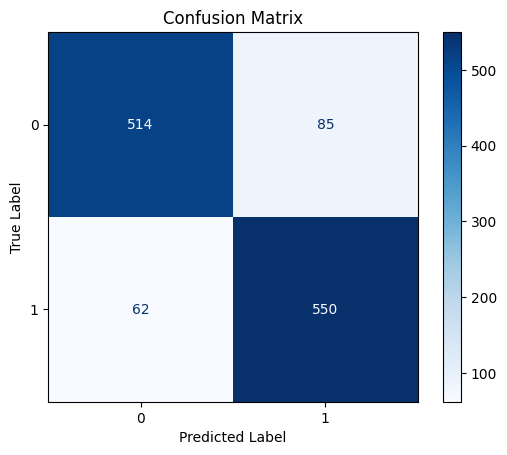

In [14]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Push to hub

In [15]:
model_name = "bert-slang-detection"

# Upload the tokenizer to the hub
tokenizer.push_to_hub(
    repo_id=model_name,
    commit_message="Add tokenizer",
    use_temp_dir=True,
)

# Upload the model to the hub
model.push_to_hub(
    repo_id=model_name,
    commit_message="Add model",
    use_temp_dir=True,
)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/SohailaMohammed/bert-slang-detection/commit/79828a078f72d98bfc52fc107ff9760accdaae24', commit_message='Add model', commit_description='', oid='79828a078f72d98bfc52fc107ff9760accdaae24', pr_url=None, pr_revision=None, pr_num=None)

In [16]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/SohailaMohammed/results_fold_4/commit/8cd856e794e134dd51f686c44012a30a98874bf4', commit_message='End of training', commit_description='', oid='8cd856e794e134dd51f686c44012a30a98874bf4', pr_url=None, pr_revision=None, pr_num=None)